# Practica 2 - Modelatge del Titanic
**Autors: Martí Paredes Salom i Sílvia Moià Canyelles.**

L'objectiu d'aquesta pràctica es divideix en dues parts:
- La primera part consisteix a entrenar un conjunt de predictors i comparar el seu rendiment. Aquests predictors han de ser: perceptró, regressió logística, arbre de decisió i random forest.

- La segona part consisteix per una part obtenir i analitzar la importància de cada característica per cada un dels models entrenats.

### Importam les llibreries a utilitzar.

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, accuracy_score, f1_score, confusion_matrix)
from sklearn.inspection import permutation_importance
import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette("YlGnBu")
import warnings
warnings.filterwarnings('ignore')

### Importam el dataset.

Emprarem la llibreria ``Panda`` on guardarem el dataset amb el nom ``df``, farem un ``head()`` per saber les labels proporcionades.

In [3]:
df = pd.read_csv("./dades.csv")
pd.set_option('display.max_columns', None)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### 1. Anàlisis i netetja dels valors proporcionats al dataset.

Primer de tot obtenim els noms de les columnes que obtenim, això ens ajudarà a saber el tipus de dades que conté el nostre dataset, també mirarem si existeixen columnes que tenen valors nulls.

In [5]:
#Obtenim el nom de les columnes i el típus de dades que representen.
df.info()
print("--------------------------------------------")
#Obtenim quines columnes contenen valors nulls.
null_columns = df.isnull().sum()
print(f"Columnes amb valors null:\n{null_columns[null_columns > 0]}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
--------------------------------------------
Columnes amb valors null:
Age         177
Cabin       687
Embarked      2
dtype: int64


Amb l'exploració anterior sabem que el dataset no conté totes les dades necessàries, en específic les ''Age'', ''Cabin'' i ''Embarked'' estan incompletes, analitzarem com omplir els valors de manera independent:

- La columna ''Age'' es tracta d'una variable típus float, per a omplir els NaNs he decidit afegir la mitjana del dataset, d'aquesta manera no perdem la fila i no afegim variació al dataset.

- La columna ''Cabin'' es tracta d'un literal però observam que de 891 mostres que té el dataset, 687 estan a NaN, per el que he suposat que significa que simplement no tenien cap cabina reservada al tiquet, substituiré els NaN per un 0 representant aquesta falta de cabina, i posaré a 1 tots els altres valors, reprenent que tenien un cabina assignat.

- I per acabar tenim la columna ''Embarked'', la qual és un String que significa desde on s'ha embracat, com només són dos valors NaNs de 891 eliminaré les dues files.

In [6]:
#Emplenar els NaNs d'Age amb la mitjana del dataset, agafarem el floor per no tenir valors decimals.
age_mean = math.floor(df['Age'].mean())
df['Age'].fillna(value=age_mean, inplace=True)

#Emplenar els NaNs de Cabin amb 0, sino posam un 1.
df['Cabin'] = df['Cabin'].replace(r'^.+$', 1, regex=True)
df['Cabin'].fillna(0, inplace=True)

#Eliminars els dos Nans de Embarked.
df.dropna(subset=['Embarked'], inplace=True)

#Comprovam que hem solucionat tots els problemes dels NaNs.
print(df.isnull().sum())
#Mostram de nou el dataset per a estudiar-lo amb més profunditat.
df.head()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,0.0,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,1.0,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,0.0,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,1.0,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,0.0,S


Una vegada hem eliminat tots els NaNs podem fer una observació més en detall de les dades, la columna ``PassengerId`` és un identificador únic el qual no ens aporta informació rellevant per el que la podem eliminar directament, ens passa el mateix amb les columnes ``Name`` i ``Ticket``.

Podem observar que la columna ``Sex`` està representat com a un String, ens pasa el mateix per ``Embarked``. Per a poder tractar millor les dades codificam la columna Sex, on 0 representa femení i 1 masculí i aplicarem One Hot Encoding per a ``Embarked``.

In [7]:
#Eliminam les columnes amb identificadors que no ens aporten res.
df.drop(columns=['PassengerId','Name','Ticket'], inplace=True)

#Aplicam one hot encoding a les colmnes Embarked.
to_convert = ['Embarked']

for columna in to_convert:
    col = df.pop(columna)
    ohe_col = pd.get_dummies(col, prefix=columna.lower())
    df = pd.concat([df.reset_index(drop=True), ohe_col.reset_index(drop=True)], axis=1, sort=False)

#Codificam la columna Sex, on 0 representa femení i 1 masculí.
df['Sex'] = df['Sex'].replace({'female': 0, 'male': 1})

print(df.info())    
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    889 non-null    int64  
 1   Pclass      889 non-null    int64  
 2   Sex         889 non-null    int64  
 3   Age         889 non-null    float64
 4   SibSp       889 non-null    int64  
 5   Parch       889 non-null    int64  
 6   Fare        889 non-null    float64
 7   Cabin       889 non-null    float64
 8   embarked_C  889 non-null    uint8  
 9   embarked_Q  889 non-null    uint8  
 10  embarked_S  889 non-null    uint8  
dtypes: float64(3), int64(5), uint8(3)
memory usage: 58.3 KB
None


,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,embarked_C,embarked_Q,embarked_S
0,0,3,1,22.0,1,0,7.2500,0.0,0,0,1
1,1,1,0,38.0,1,0,71.2833,1.0,1,0,0
2,1,3,0,26.0,0,0,7.9250,0.0,0,0,1
3,1,1,0,35.0,1,0,53.1000,1.0,0,0,1
4,0,3,1,35.0,0,0,8.0500,0.0,0,0,1


Ara ja tenim el dataset '*net*' i procedirem a fer les visualitzacions i proves per a arribar a conclusions sobre aquest.

#### 1.1 Visualització de les dades.

Percenatatge d'individus que van sobreviure:
Sobreviure : 38.25% (340)
No sobreviure : 61.75% (549)


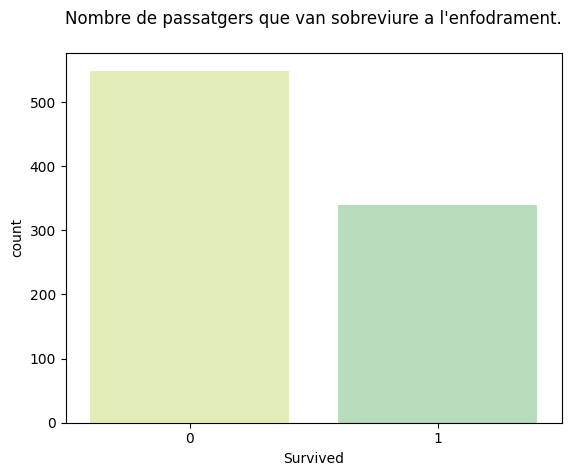

In [8]:
print("Percenatatge d'individus que van sobreviure:")
surv_p = df['Survived'].value_counts(normalize=True) * 100
surv_d = df['Survived'].value_counts()
print(f"Sobreviure : {round(surv_p[1],2)}% ({surv_d[1]})\nNo sobreviure : {round(surv_p[0],2)}% ({surv_d[0]})")

plt.title("Nombre de passatgers que van sobreviure a l'enfodrament.\n")
sns.countplot(x="Survived",data=df) 
plt.show()


Percenatatje d'individus per sexe:
Femení : 35.1% (312)
Masculí : 64.9% (577)

Sex              0         1
Survived                    
0         0.147541  0.852459
1         0.679412  0.320588 

 Sex         0    1
Survived          
0          81  468
1         231  109


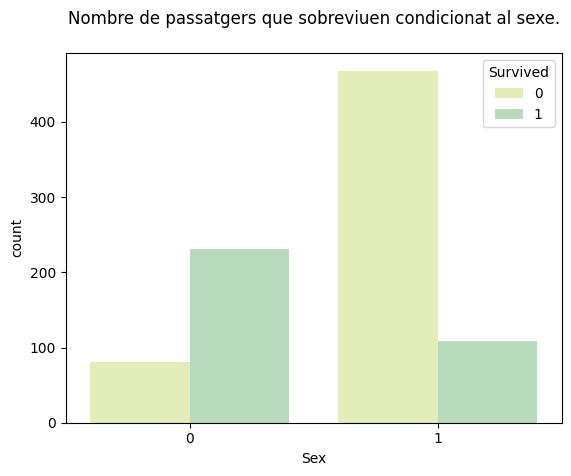

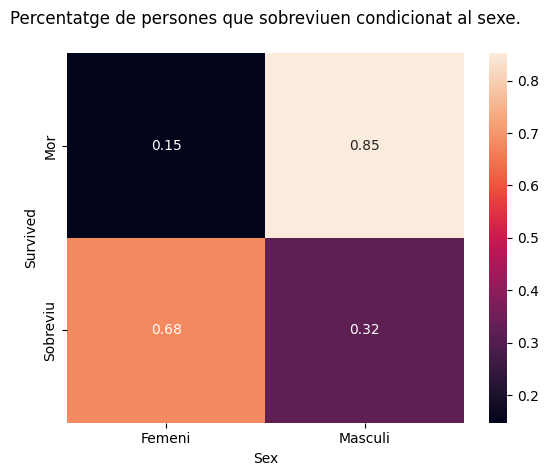

In [9]:
print("\nPercenatatje d'individus per sexe:")
fem_p = df['Sex'].value_counts(normalize=True) * 100
fem_d = df['Sex'].value_counts()
print(f"Femení : {round(fem_p[0],2)}% ({fem_d[0]})\nMasculí : {round(fem_p[1],2)}% ({fem_d[1]})\n")

ct = pd.crosstab(df['Survived'], df['Sex'], normalize='index')
pt = df.pivot_table(index='Survived', columns='Sex', aggfunc='size')
print(ct,"\n\n",pt)

sns.countplot(x="Sex",data=df,hue="Survived")
plt.title("Nombre de passatgers que sobreviuen condicionat al sexe.\n")
plt.show()

sns.heatmap(ct, annot=True, 
                xticklabels=['Femeni', 'Masculi'], 
                yticklabels=['Mor', 'Sobreviu'])

plt.title("Percentatge de persones que sobreviuen condicionat al sexe.\n")
plt.show()

En aquesta taula podem observar com del **38%** de les persones que van **sobreviure**, un **68%** (231) persones eren **dones** i el **32%** restant (109 persones) eren **homes**, això ens sorprèn una mica, ja que del total, només un 35% eren dones. No obstant això ens coincideix amb el criteri d'evacuar primer a dones i nins en cas d'un accident.

Ara repetirem l'apartat anterior però canviant la característica ``Survived`` per la ``Pclass`` per analitzar si com millor era la classe en la qual viatjaves tenies més possibilitats de sobreviure.


Percenatatge d'individus per classe:
Clase 1 : 24.07% (214)
Clase 2 : 20.7% (184)
Clase 3 : 55.23% (491)



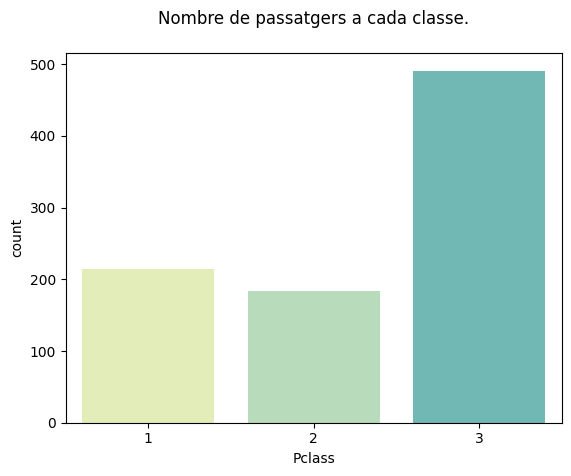

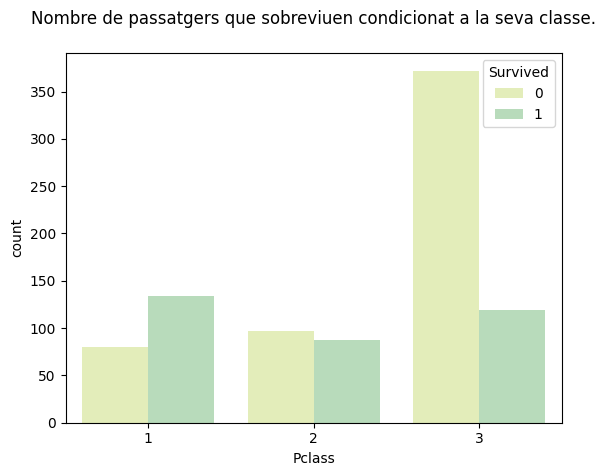

In [10]:
print("\nPercenatatge d'individus per classe:")
class_p = df['Pclass'].value_counts(normalize=True) * 100
class_d = df['Pclass'].value_counts()
print(f"Clase 1 : {round(class_p[1],2)}% ({class_d[1]})\nClase 2 : {round(class_p[2],2)}% ({class_d[2]})\nClase 3 : {round(class_p[3],2)}% ({class_d[3]})\n")

sns.countplot(x="Pclass",data=df)
plt.title("Nombre de passatgers a cada classe.\n")
plt.show()

'''
ct = pd.crosstab(df['Survived'], df['Pclass'], normalize='index')
pt = df.pivot_table(index='Survived', columns='Pclass', aggfunc='size')
print(ct,"\n\n",pt)
'''

sns.countplot(x="Pclass",data=df,hue="Survived")
plt.title("Nombre de passatgers que sobreviuen condicionat a la seva classe.\n")
plt.show()

Com podem observar el percentatge de persones que si se salven és major en la **classe 1** (la més cara) es va salvar un **62%** dels individus, representant un **39%** del total salvats (134). En la **classe 2** es va salvar un **56%** dels individus, representant un **25%** (87) del total salvats, i, finalment de la **classe 3** (la més barata) es va salvar un **24%**, representant un **35%** (119) dels individus salvats.

A continuació estudiarem la població que es va salvar al naufragi observant l'edat dels passatgers, per a poder fer un a represetnació gràfica he hagut de dividir les dades en cinc conjunts:

- Menos de 18.
- Entre 18 i 25.
- Entre 25 i 45.
- Entre 45 i 60.
- Mes de 60.

Per a obtenir aquests subgrups i graficar les dades he emprat el següent codi:

Entre 25 i 45    486
Entre 18 i 25    162
Menos de 18      139
Entre 45 i 60     81
Mes de 60         21
Name: edad_categoria, dtype: int64
Survived               
0         Entre 25 i 45    307
          Entre 18 i 25    108
          Menos de 18       69
          Entre 45 i 60     48
          Mes de 60         17
1         Entre 25 i 45    179
          Menos de 18       70
          Entre 18 i 25     54
          Entre 45 i 60     33
          Mes de 60          4
Name: edad_categoria, dtype: int64


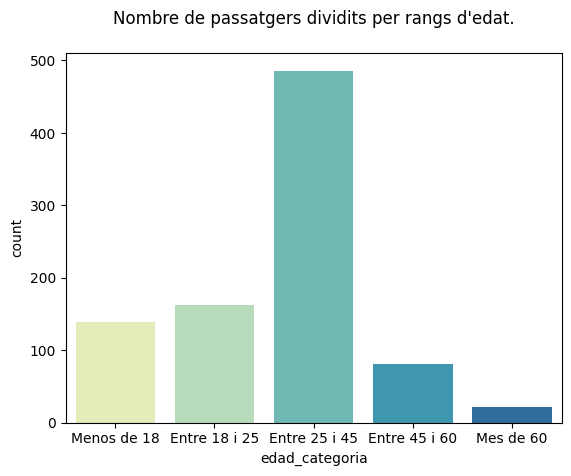

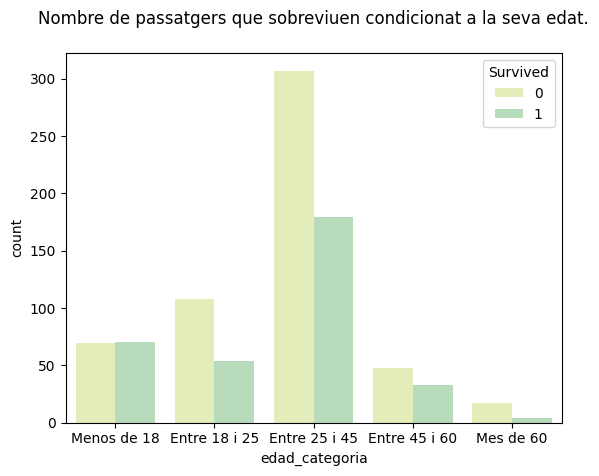

In [11]:
# Definim els límits dels rangs d'edat.
bins = [0, 18, 25, 45, 60, 100]

# Assignam el nom respecte a l'array anterior.
labels = ["Menos de 18", "Entre 18 i 25", "Entre 25 i 45", "Entre 45 i 60", "Mes de 60"]
new_df = df[["Survived", "Age"]]


# Dividim amb els intervals i assignam les etiquetes corresponents.
new_df['edad_categoria'] = pd.cut(df["Age"], bins=bins, labels=labels)

print(new_df["edad_categoria"].value_counts())

print(new_df.groupby('Survived')['edad_categoria'].value_counts())

# Contam la quantitat d'aparcicions per a cada interval i cream un gràfic de barres.
sns.countplot(data=new_df, x="edad_categoria")
plt.title("Nombre de passatgers dividits per rangs d'edat.\n")
plt.show()

sns.countplot(data=new_df, x="edad_categoria", hue="Survived")
plt.title("Nombre de passatgers que sobreviuen condicionat a la seva edat.\n")
plt.show()

Com podem observar el grup que és va salvar més gent a l'enfondrament és el '**Entre 25 i 45**' anys, amb un total de 179 passatgers salvats d'un total de 486, representant un **36%** del grup. En canvi si enlloc del número ens centram en el **percentatge de passatgers salvats** ens surt que el millor és el del '**Menos de 18**', on de 139 passatgers 70 és van salvar, representant un **51%**. De manera gràfica podem observar que el seguent grup amb millor porcentatje de salvats es el de 'Entre 18 i 25' i **el pitjor**, tant amb porcentatge com a numeros, és el de '**Més de 60**'.

A continuació farem l'estudi de com va influir si tenies o no una cabina assiganda en el moment de l'enfondrament.

0.0    687
1.0    202
Name: Cabin, dtype: int64
Survived  Cabin
0         0.0      481
          1.0       68
1         0.0      206
          1.0      134
Name: Cabin, dtype: int64


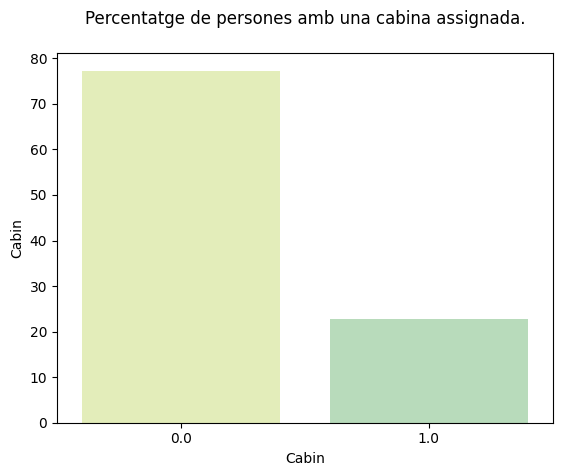

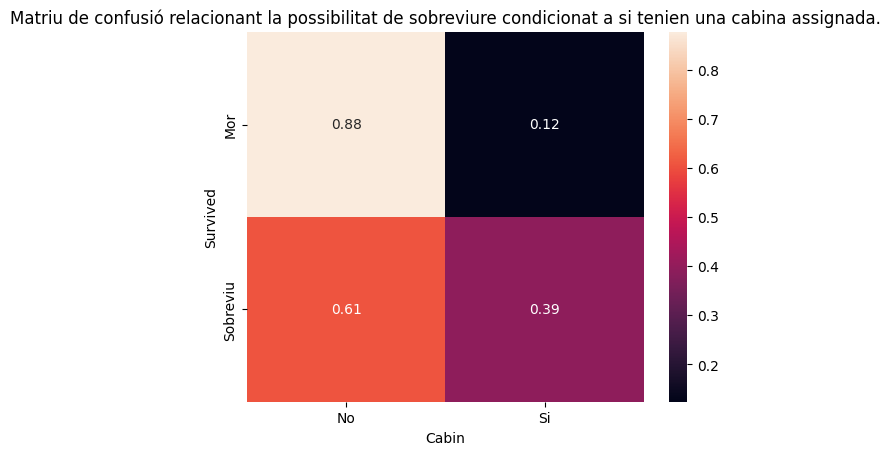

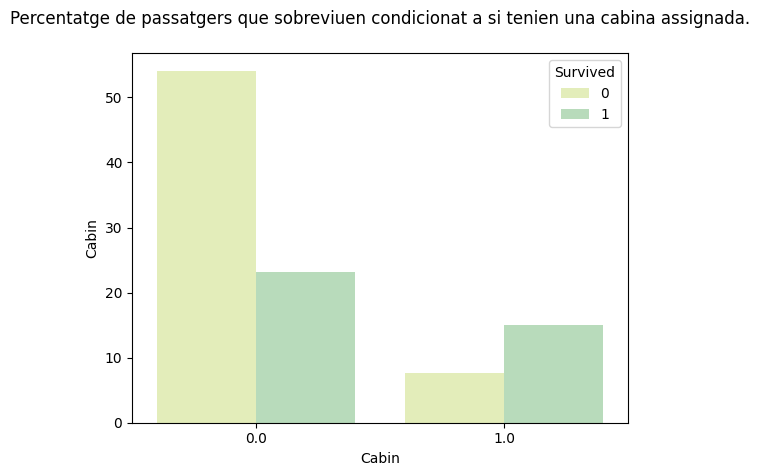

In [12]:
print(df["Cabin"].value_counts())
print(df.groupby('Survived')['Cabin'].value_counts())

sns.barplot(data=df, x="Cabin", y="Cabin", estimator=lambda x: len(x) / len(df) * 100)
plt.title("Percentatge de persones amb una cabina assignada.\n")
plt.show()

ct = pd.crosstab(df['Survived'], df['Cabin'], normalize='index')
sns.heatmap(ct, annot=True, 
                xticklabels=['No', 'Si'], 
                yticklabels=['Mor', 'Sobreviu'])
plt.title("Matriu de confusió relacionant la possibilitat de sobreviure condicionat a si tenien una cabina assignada.")
plt.show()

sns.barplot(data=df, x="Cabin", y="Cabin", hue="Survived", estimator=lambda x: len(x) / len(df) * 100)
plt.title("Percentatge de passatgers que sobreviuen condicionat a si tenien una cabina assignada.\n")
plt.show()

Com podem observar la majoria de gent no tenia una cabina assignada, això pot ser a que depengues de la categoria en la que estaves i que únicament la gent amb la millor categoria tengues una cabina. Per altre banda podem observar de les 202 persones amb cabina es varen salvar 134, represenant un 66% del grup i un 40% del total de passatgers salvats. En canvi de la gent que no tenia cabina només es varen salvar 206 de 687 passatgers, es a dir, un 30% del grup.

El seguent camp que analitzare és el de ``sibsp`` i el de ``parch``, com els dos camps estan relacionats amb el nombre de familiars abord he decidit juntar les dues classes per a fer la representació.

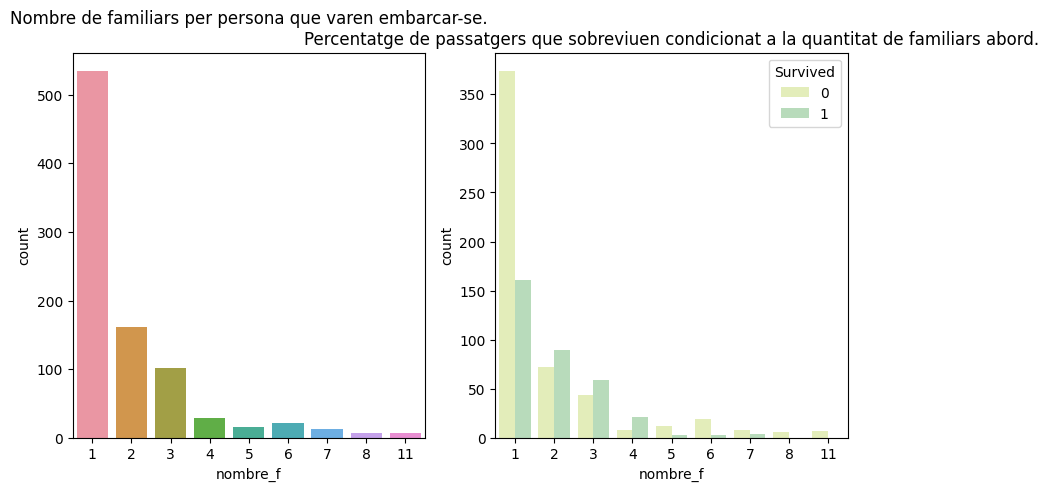

In [13]:
# Afegim al dataset de proves una nova columna.
new_df["nombre_f"] = df["SibSp"] + df["Parch"] + 1

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(data=new_df, x="nombre_f", ax=axs[0])
axs[0].set_title("Nombre de familiars per persona que varen embarcar-se.\n")

sns.countplot(data=new_df, x="nombre_f", hue="Survived", ax=axs[1])
axs[1].set_title("Percentatge de passatgers que sobreviuen condicionat a la quantitat de familiars abord.")
plt.show()

Com podem observar el més comú era que la persona viatjas sola (535) i amesura que tenia més familiars baixa el nombre de famílies. Els grups amb millor porcentatje són els de dos, tres i quatre familiars, i el pitjors el de vuit i once familiars.

### 1.2. Entrenament dels diferents models. 

El primer pas per a poder entrenar els diferents models es separa el dataframe netejat en dos, un conjunt que emprarem per entrenar als models, les dades train, i un altre conjunt que emprarem per verificar com de bé funciona el model, les dades test.

In [14]:
#Separam les dades del resultat.
survived = df['Survived']
data = df.iloc[:,1:]
#Dividim el conjunt en quatre (train i test) i assignam una semilla per a reproduir els resultats.
X_train, X_test, y_train, y_test = train_test_split(data, survived, test_size=0.33, random_state=42)

Una vegada tenim les dades separades i etiquetades podem començar amb els models de predicció. El primer model és el perceptró, per emprar-ho crearem un objecte ``linear_model.Perceptron`` de la llibreria ``sklearn`` (*Emprarem aquesta llibreria per tots el models de predicció*), a continuació l'entrenarem amb les dades train i obtendrem les mètriques per avaluar els resultats predits, per l'obtenció de les mètriques definirè una funció ja que seran les mateixes per a cada model.

In [15]:
def obtenir_metriques(model):
    report = classification_report(y_test, model, output_dict=True)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    accuracy = report['accuracy']
    recall = report['1']['recall']
    f1_score = report['1']['f1-score']

    df_report = pd.DataFrame({'Metric': ['Accuracy', 'Recall', 'F1-score'],'Value': [accuracy, recall, f1_score]})
    sns.barplot(x='Metric', y='Value', data=df_report, ax=axs[0])
    axs[0].set_title("Valors de les métriques.")
    
    c_matrix = confusion_matrix(y_test, model)
    sns.heatmap(c_matrix, annot=True, fmt='d', cmap='YlGnBu', 
                xticklabels=['Predicción: No', 'Predicción: Si'], 
                yticklabels=['Real: No', 'Real: Si'], ax=axs[1])
    axs[1].set_title("Matriu de confusió - Sobreviu al naufragi?")
    plt.show()    
    print(f"Acurracy {accuracy}, Recall {recall}, F1 {f1_score}")

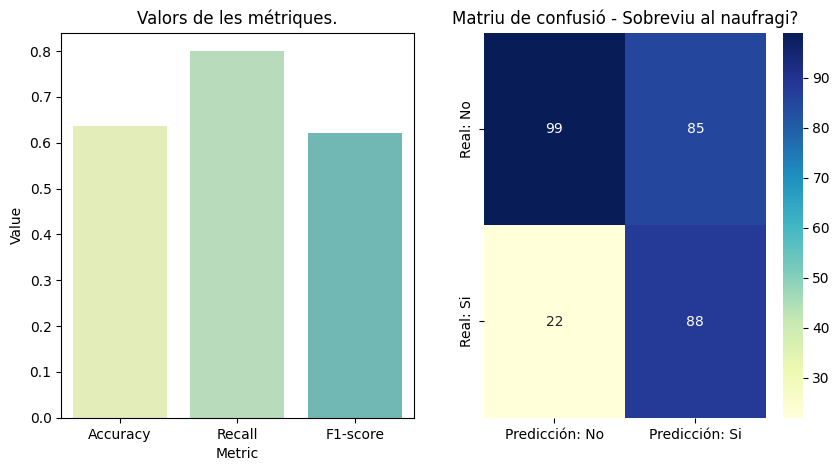

Acurracy 0.6360544217687075, Recall 0.8, F1 0.6219081272084805


In [16]:
# Cream l'objecte Perceptron.
perceptro = linear_model.Perceptron(tol=1e-3, random_state=42)

# Subministram les dades de train i l'entrnam.
perceptro.fit(X_train, y_train)

# Feim una predicció sobre les dades de test.
prediccio_perceptro = perceptro.predict(X_test)

# Obtenim les mètriques d'avaluació.
obtenir_metriques(prediccio_perceptro)

El segon model a avaluar és la regressió logística, necessitarem crear un objecte ``linear_model.LogisticRegression`` i seguirem els mateixos passos que en el perceptró.

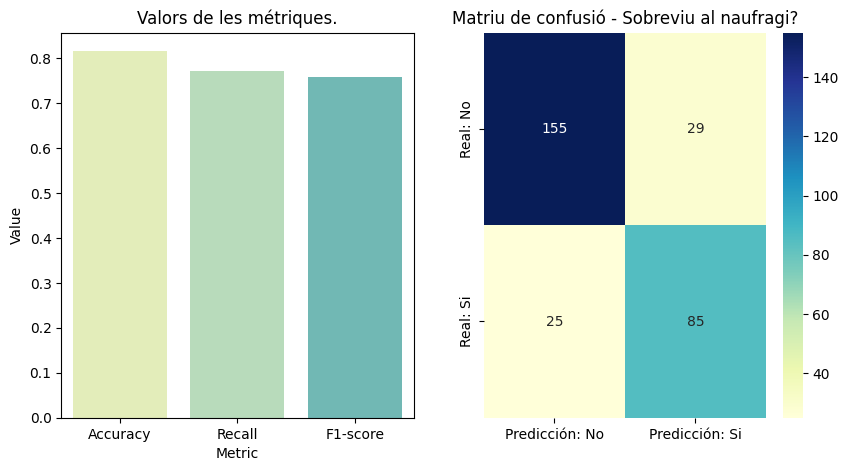

Acurracy 0.8163265306122449, Recall 0.7727272727272727, F1 0.7589285714285713


In [17]:
# Cream l'objecte LogisticRegression.
regression = linear_model.LogisticRegression(fit_intercept=True)

# Subministram les dades de train i l'entrnam.
regression.fit(X_train, y_train)

# Feim una predicció sobre les dades de test.
prediccio_regressio = regression.predict(X_test)

# Obtenim les mètriques d'avaluació.
obtenir_metriques(prediccio_regressio)

A continuació crearem el model d'arbre de decisió, ara emprarem l'objecte ``DecisionTreeClassifier``.

Mètriques d'avaluació d'un arbre de decisió:


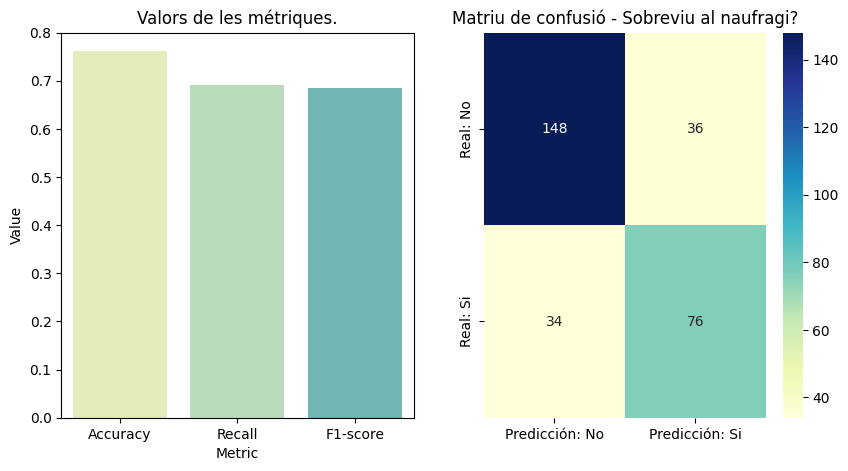

Acurracy 0.7619047619047619, Recall 0.6909090909090909, F1 0.6846846846846847


In [18]:
# Cream l'objecte DecisionTreeClassifier.
arbre_decisio = DecisionTreeClassifier()
# Subministram les dades de train i l'entrnam.
arbre_decisio.fit(X_train, y_train)

# Feim una predicció sobre les dades de test.
prediccio_arbre = arbre_decisio.predict(X_test)

print("Mètriques d'avaluació d'un arbre de decisió:")
obtenir_metriques(prediccio_arbre)

I per acabar crearem el Random Tree.

Mètriques d'avaluació d'un bosc aleatori de classificació:


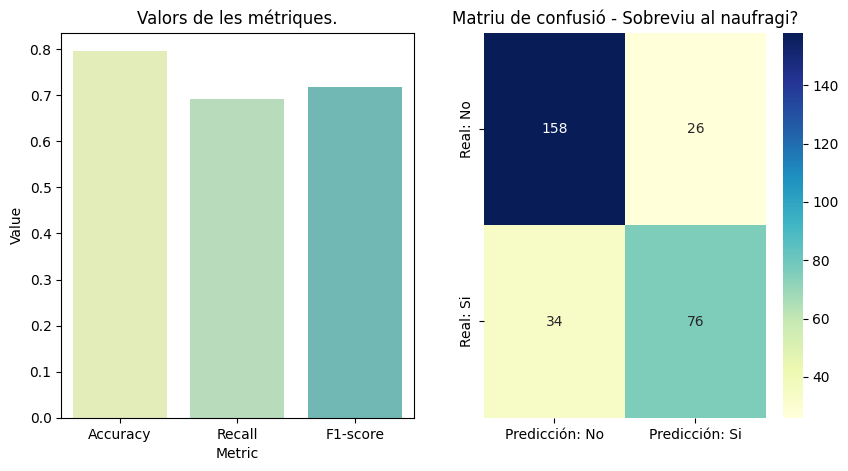

Acurracy 0.7959183673469388, Recall 0.6909090909090909, F1 0.7169811320754716


In [19]:
#Cream l'objecte RandomForestClassifier.
bosc_random = RandomForestClassifier()
#Subministram les dades de train i l'entrnam.
bosc_random.fit(X_train, y_train)

#Feim una predicció sobre les dades de test.
prediccio_arbre_rand = bosc_random.predict(X_test)

print("Mètriques d'avaluació d'un bosc aleatori de classificació:")
obtenir_metriques(prediccio_arbre_rand)

### 1.3. Avaluació dels diferents models. 

#### Dels diferenents models de predicció podem extreure les seguents métriques.

|                      | _Precisió_ |_Recall_| _F1_ |  
|----------------------|------------|--------|------|
| _Perceptró_          |   63.6%    |  0.8   | 0.62 |  
| _Regresió logistica_ |   81.63%   |  0.77  | 0.76 | 
| _Arbre de decisió_   |   75.51%   |  0.68  | 0.68 | 
| _Random forest_      |   79.93%   |  0.7   | 0.72 | 

D'aquestes mètriques podem arribar a la conclusió que el model **regresió logistica** model per a aquest problema amb el modelatge de dades que he fet el qual ens ofereix una precisió aproximada del **81.63%**.

## Segona part de la pràctica. Obtenció i anàlisis dels Hyper-Parameters Tuning i extracció del les _important features_.

### 2.1. Hyper-Parameters Tuning.

A l'apartat anterior hem descobert que el model que ens aporta més precisió és la regresió logistica. En aquesta segona part de la pràctica hem de fer un anàlisi de quins paràmetres del model ens aporta un millor resultat, al procés d'obtenció i anàlisis de les important features s'anomena Hyper-Parameters Tuning, aplicarem aquesta tècnica a tots els models crats a l'apartat anterior.

Per a trobar aquests paràmetres emprarem ``Grid Search``, aquesta funció la tenim al paquet ``sklearn`` representat per la funció ``GridSearchCV``. La funció té un conjunt de valors predefinits per a cada paràmetre, i fa una combinació de tots aquests valors per a cada paràmetre per a entrenar el model i avaluar la qualitat del model amb cada combinació de paràmetres. Això es fa amb l'objectiu de trobar la millor combinació de paràmetres per a aconseguir el millor rendiment del model.

Primer hem de decobrir quins paràmetres tenen les funcion per defecte perquè tenguin més sentit.

In [20]:
# Valors per defecte del perceptro.
print(f"Valors per defecte del perceptro:\n{perceptro.get_params()})\n")

# Valors per defecte de la regresió logistica.
print(f"Valors per defecte de la regresió logistica:\n{regression.get_params()}\n")

# Valors per defecte del arbre de decisió.
print(f"Valors per defecte del del arbre de decisió:\n{arbre_decisio.get_params()}\n")

# Valors per defecte del random forest.
print(f"Valors per defecte del random forest:\n{bosc_random.get_params()}")

Valors per defecte del perceptro:
{'alpha': 0.0001, 'class_weight': None, 'early_stopping': False, 'eta0': 1.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'max_iter': 1000, 'n_iter_no_change': 5, 'n_jobs': None, 'penalty': None, 'random_state': 42, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False})

Valors per defecte de la regresió logistica:
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}

Valors per defecte del del arbre de decisió:
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'best'}

Valors pe

Cerca dels hyper-paràmetres amb el Grid Search.
{'eta0': 0.5, 'max_iter': 250}


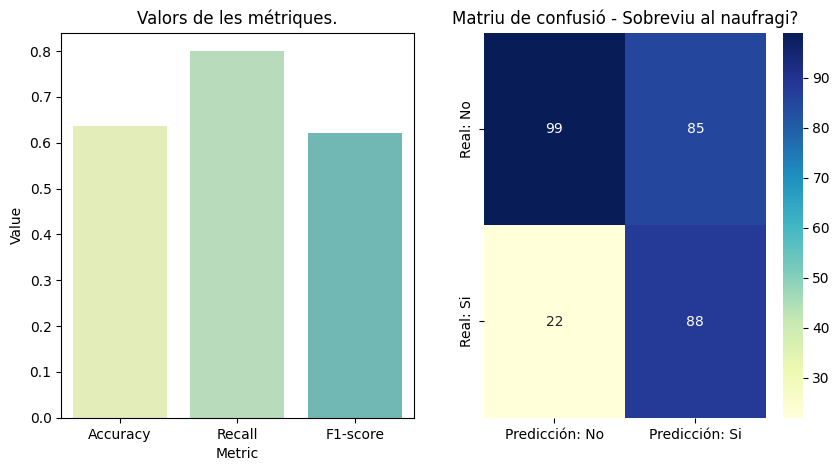

Acurracy 0.6360544217687075, Recall 0.8, F1 0.6219081272084805


In [21]:
#Definim els paràmetres amb els quals farem l'ajustament.
parametres = {'eta0': [0.5, 0.75, 1, 1.25, 1.5],
              'max_iter': [250, 500, 750, 1000, 1250, 1500, 1750]}

#Cream un objecte de cerca en quadrícula amb els paràmetres designats.
cerca_quadricula = GridSearchCV(perceptro, parametres, cv=5)
#Subministram les dades de train i l'entrnam.
cerca_quadricula.fit(X_train, y_train)

# Mostram quins han estat els millors hyper-paràmetres.
print("Cerca dels hyper-paràmetres amb el Grid Search.")
print(cerca_quadricula.best_params_)

#Cream un nou model amb els nous paràmetres.
perceptro_millorat = cerca_quadricula.best_estimator_
perceptro_millorat.fit(X_train, y_train)

# Evaluar el rendimiento del modelo ajustado en el conjunto de prueba
pred_perceptro_millorat = perceptro_millorat.predict(X_test)

#Obtenim les mètriques d'avaluació de l'arbre millorat.
obtenir_metriques(pred_perceptro_millorat)

Cerca dels hyper-paràmetres amb el Grid Search.
{'max_iter': 500, 'solver': 'lbfgs'}


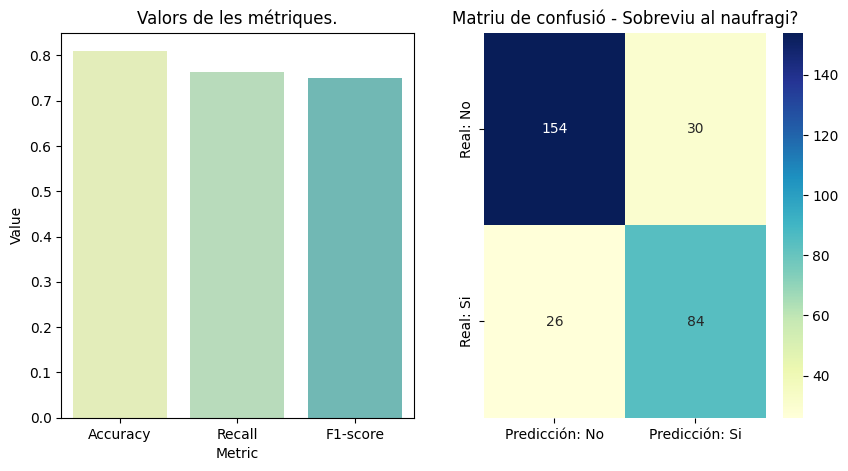

Acurracy 0.8095238095238095, Recall 0.7636363636363637, F1 0.7499999999999999


In [22]:
#Definim els paràmetres amb els quals farem l'ajustament.
parametres = {'solver': ["lbfgs", "liblinear", "sag"],
              'max_iter': [250, 500, 750, 1000, 1250, 1500, 1750]  }

#Cream un objecte de cerca en quadrícula amb els paràmetres designats.
cerca_quadricula = GridSearchCV(regression, parametres, cv=5)
#Subministram les dades de train i l'entrnam.
cerca_quadricula.fit(X_train, y_train)

# Mostram quins han estat els millors hyper-paràmetres.
print("Cerca dels hyper-paràmetres amb el Grid Search.")
print(cerca_quadricula.best_params_)

#Cream un nou model amb els nous paràmetres.
regressio_millorat = cerca_quadricula.best_estimator_
regressio_millorat.fit(X_train, y_train)

# Evaluar el rendimiento del modelo ajustado en el conjunto de prueba
pred_regressio_millorat = regressio_millorat.predict(X_test)

#Obtenim les mètriques d'avaluació de l'arbre millorat.
obtenir_metriques(pred_regressio_millorat)

Cerca dels hyper-paràmetres amb el Grid Search.
{'max_depth': 3, 'min_samples_leaf': 3}


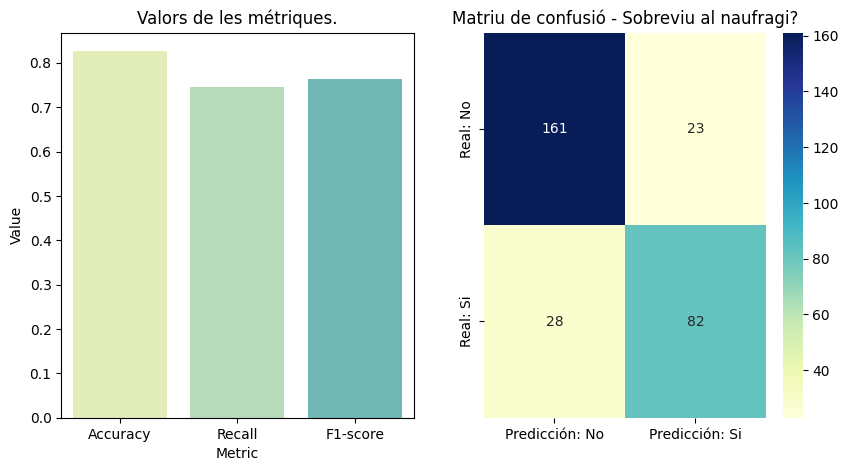

Acurracy 0.826530612244898, Recall 0.7454545454545455, F1 0.7627906976744186


In [23]:
#Definim els paràmetres amb els quals farem l'ajustament.
parametres = {'max_depth': [1, 3, 5, 7, 9],
              'min_samples_leaf': [1, 2, 3, 4, 5, 6]}

#Cream un objecte de cerca en quadrícula amb els paràmetres designats.
cerca_quadricula = GridSearchCV(arbre_decisio, parametres, cv=5)
#Subministram les dades de train i l'entrnam.
cerca_quadricula.fit(X_train, y_train)

# Mostram quins han estat els millors hyper-paràmetres.
print("Cerca dels hyper-paràmetres amb el Grid Search.")
print(cerca_quadricula.best_params_)

#Cream un nou model amb els nous paràmetres.
arbre_millorat = cerca_quadricula.best_estimator_
arbre_millorat.fit(X_train, y_train)

# Evaluar el rendimiento del modelo ajustado en el conjunto de prueba
prediccio_arbre_millorat = arbre_millorat.predict(X_test)

#Obtenim les mètriques d'avaluació de l'arbre millorat.
obtenir_metriques(prediccio_arbre_millorat)

Cerca dels hyper-paràmetres amb el Grid Search.
{'max_depth': 7, 'min_samples_leaf': 1}


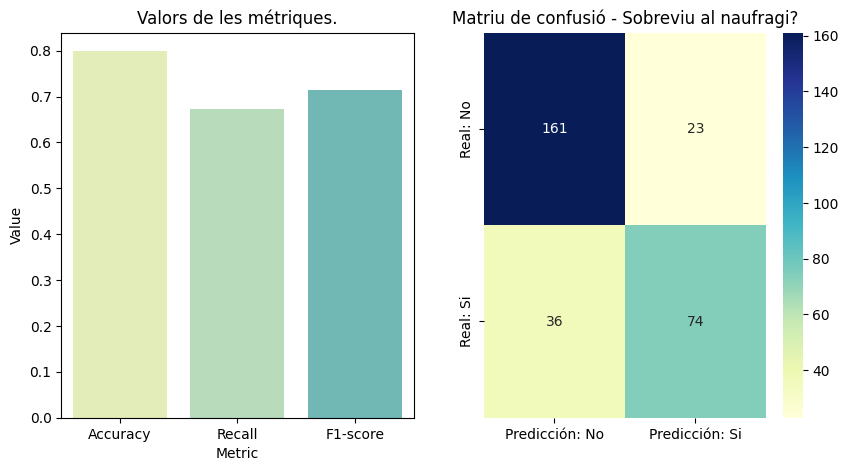

Acurracy 0.7993197278911565, Recall 0.6727272727272727, F1 0.7149758454106279


In [24]:
#Definim els paràmetres amb els quals farem l'ajustament.
parametres = {'max_depth': [1, 3, 5, 7, 9],
              'min_samples_leaf': [1, 2, 3, 4, 5, 6]}

#Cream un objecte de cerca en quadrícula amb els paràmetres designats.
cerca_quadricula = GridSearchCV(bosc_random, parametres, cv=5)
#Subministram les dades de train i l'entrnam.
cerca_quadricula.fit(X_train, y_train)

# Mostram quins han estat els millors hyper-paràmetres.
print("Cerca dels hyper-paràmetres amb el Grid Search.")
print(cerca_quadricula.best_params_)

#Cream un nou model amb els nous paràmetres.
bosc_millorat = cerca_quadricula.best_estimator_
bosc_millorat.fit(X_train, y_train)

# Evaluar el rendimiento del modelo ajustado en el conjunto de prueba
pred_bosc_millorat = bosc_millorat.predict(X_test)

#Obtenim les mètriques d'avaluació de l'arbre millorat.
obtenir_metriques(pred_bosc_millorat)

Amb els nous hyper-paràmetres obtenim les seguents mètriques d'evaluació:

|                      | _Precisió_ |_Recall_| _F1_ |  
|----------------------|------------|--------|------|
| _Perceptró_          |   63.6%    |  0.8   | 0.62 |  
| _Regresió logistica_ |   80.95%   |  0.77  | 0.76 | 
| _Arbre de decisió_   |   82.65%   |  0.74  | 0.76 | 
| _Random forest_      |   80.61%   |  0.67  | 0.72 | 

Obtenim que el millor model en quant a precisió es el **arbre de decisió amb un 82.65 %** de precisió, 0.74 de recall i 0.76 de score F1.

### 2.2. Important features.

A continuació obtendrem les important features dels diferents models, les important features són el pes que li dona cada model als diferents models per a fer la predicció, per a l'arbre de decisió i al random forest existeix l'atribut ``.feature_importances_``, per al perceptró i la regressió logistica emprarem al funció ``permutation_importance``, aquest mètode avalua com el rendiment del model es veu afectat quan es permuten aleatòriament els valors d'una característica donada. Si permutar els valors d'una característica té un gran impacte en el rendiment del model, llavors aquesta característica és considerada important per al model.

In [25]:
importances = permutation_importance(perceptro_millorat, X_train, y_train, n_repeats=10, random_state=42)
print("Important features del model: Perceptro")

indices = importances.importances_mean.argsort()[::-1]
for i in range(X_train.shape[1]):
    print(f"{X_train.columns[indices[i]]}: {importances.importances_mean[indices[i]]}")

Important features del model: Perceptro
Fare: 0.12957983193277314
Sex: 0.02789915966386556
Age: 0.02756302521008406
Cabin: 0.004873949579831916
embarked_S: 0.0018487394957983128
embarked_C: 0.0013445378151260457
embarked_Q: 0.0001680672268907557
SibSp: 1.1102230246251566e-17
Pclass: 0.0
Parch: -0.0020168067226890686


In [26]:
importances = permutation_importance(regressio_millorat, X_train, y_train, n_repeats=10, random_state=42)
print("Important features del model: Regressió Logistica")

indices = importances.importances_mean.argsort()[::-1]
for i in range(X_train.shape[1]):
    print(f"{X_train.columns[indices[i]]}: {importances.importances_mean[indices[i]]}")

Important features del model: Regressió Logistica
Sex: 0.20184873949579832
Pclass: 0.018655462184873916
Age: 0.009747899159663832
SibSp: 0.006218487394957961
Parch: 0.0003361344537815114
embarked_Q: -0.001680672268907557
Fare: -0.001680672268907557
embarked_C: -0.00352941176470587
embarked_S: -0.005378151260504183
Cabin: -0.008403361344537796


In [27]:
importances = arbre_millorat.feature_importances_
print("Important features del model: Arbre de decisió")

indices = importances.argsort()[::-1]

for i in range(X_train.shape[1]):
    print(f"{X_train.columns[indices[i]]}: {importances[indices[i]]}")

Important features del model: Arbre de decisió
Sex: 0.6246595701389611
Pclass: 0.16618890198658837
Age: 0.08370491448810591
Cabin: 0.0691107375131792
Fare: 0.05633587587316526
embarked_S: 0.0
embarked_Q: 0.0
embarked_C: 0.0
Parch: 0.0
SibSp: 0.0


In [28]:
importances = bosc_millorat.feature_importances_
print("Important features del model: Random Forest")

indices = importances.argsort()[::-1]

for i in range(X_train.shape[1]):
    print(f"{X_train.columns[indices[i]]}: {importances[indices[i]]}")

Important features del model: Random Forest
Sex: 0.358255281968668
Fare: 0.18919156618246574
Age: 0.14317634698820622
Pclass: 0.11209443311749785
Cabin: 0.05355404462253309
SibSp: 0.051035247351689135
Parch: 0.04248819163215357
embarked_C: 0.02011021055188169
embarked_S: 0.019785612402928646
embarked_Q: 0.010309065181976093


## 3. Conclusions de la pràctica.

Durant l'exploració de les dades hem observat estadístiques que ens semblen raonables com per exemple, com més elevat sigui el preu de billet tens una categoria millor i, per tant, com més categoria més probabilitat de sobreviure. També esperàvem que el nombre de passatgers que van sobreviure estigui una mica més equilibrat quant a sexe, més un 60 % dones 40 % homes no un 85 % dones 15 % homes ens ha sorprès.

**Sense la modificació dels hyper-paràmetres** ens ha sortit que la **regressió logística** era el millor model, amb un 81,63 % de precisió, aquest model dona més importància al sexe (0.2) i després a la classe (0.02) i a l'edat (0.01), als altres paràmetres li dona una importància molt baixa, de menys del 0,005.

Una vegada hem **fet la modificació dels hyper-paràmetres** hem obtingut que el millor model és l'**arbre de decisió**, passant d'un **75.51%** de precisió a un **82.65 %**, un **augment aproximat del 10%**. Aquest model li dona més importància al sexe (0.6), comparant amb els altres models és un nombre molt major als altres, això té sentit perquè és un dels paràmetres que més diferència té dels altres, a continuació li dona més importància a la classe (0.16) i a l'edat (0.08).

#### Fonts i recursos emprats durant la pràctica:
- https://www.kaggle.com/competitions/titanic
- https://www.kaggle.com/code/vinothan/titanic-model-with-90-accuracy/notebook
- https://www.kaggle.com/code/idebmalya/titanic-disaster-survival-prediction
- https://www.kaggle.com/code/sagarlokesh/titanic-model-accuracy-82
- https://seaborn.pydata.org/installing.html
- https://chat.openai.com/